# Srovnání modelů na klasifikaci fotek prostředí

Pro analýzu jsem si vybral dataset https://www.kaggle.com/datasets/puneet6060/intel-image-classification


In [2]:
# Importy
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.discriminant_analysis import StandardScaler
import tensorflow as tf
from keras import models, layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Rozbor datasetu

## Načtení dat ze souborů

In [6]:
# Inicializace proměnných
seg_train = Path.cwd() / "seg_train"
seg_test = Path.cwd() / "seg_test"
x_train = []
y_train = []
x_test = []
y_test = []
img_size = (32, 32)
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]


# Čtení dat ze souborů
for category_idx, category in enumerate(categories):
    for file in os.listdir(os.path.join(seg_train, category)):
        img_path = os.path.join(seg_train, category, file)
        img = imread(img_path)
        x_train.append(img)
        y_train.append(category_idx)
    for file in os.listdir(os.path.join(seg_test, category)):
        img_path = os.path.join(seg_test, category, file)
        img = imread(img_path)
        x_test.append(img)
        y_test.append(category_idx)

## Analýza datasetu

V další buňce lze vidět že data jsou relativně rovnoměrně rozdělena, díky tomu je možné bezpečně trénovat model.

In [39]:
print(
    f"""
Počet trénovacích fotek: {len(x_train)}     
Počet testovacích fotek: {len(x_test)}              
Struktura každé fotky: {x_train[0].shape}

Počet výskytů v každé kategorii: {np.unique(y_train, return_counts=True)[1]}
Počet výskytů v každé kategorii: {np.unique(y_test, return_counts=True)[1]}
"""
)


Počet trénovacích fotek: 14034     
Počet testovacích fotek: 3000              
Struktura každé fotky: (150, 150, 3)

Počet výskytů v každé kategorii: [2191 2271 2404 2512 2274 2382]
Počet výskytů v každé kategorii: [437 474 553 525 510 501]



## Ukázka fotek datasetu

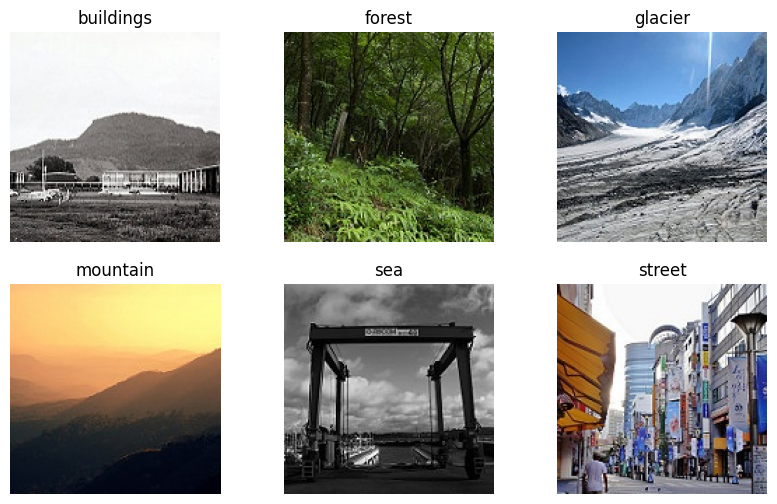

In [40]:
plt.figure(figsize=(10, len(category)))
for category_idx, category in enumerate(categories):
    img_index = y_train.index(category_idx)
    plt.subplot(2,3,category_idx+1)
    plt.imshow(x_train[img_index])
    plt.axis("off")
    plt.title(category)
plt.show()  

# Porovnání klasifikátorů

              precision    recall  f1-score   support

   buildings       0.50      0.57      0.53       437
      forest       0.78      0.80      0.79       474
     glacier       0.62      0.64      0.63       553
    mountain       0.63      0.65      0.64       525
         sea       0.60      0.40      0.48       510
      street       0.64      0.72      0.68       501

    accuracy                           0.63      3000
   macro avg       0.63      0.63      0.63      3000
weighted avg       0.63      0.63      0.63      3000



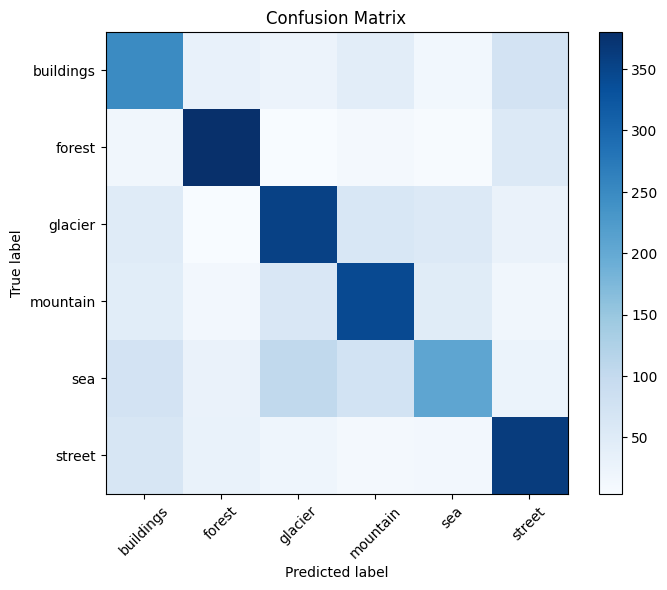

              precision    recall  f1-score   support

   buildings       0.51      0.43      0.47       437
      forest       0.70      0.81      0.75       474
     glacier       0.58      0.62      0.60       553
    mountain       0.59      0.69      0.64       525
         sea       0.59      0.43      0.50       510
      street       0.65      0.66      0.66       501

    accuracy                           0.61      3000
   macro avg       0.60      0.61      0.60      3000
weighted avg       0.61      0.61      0.60      3000



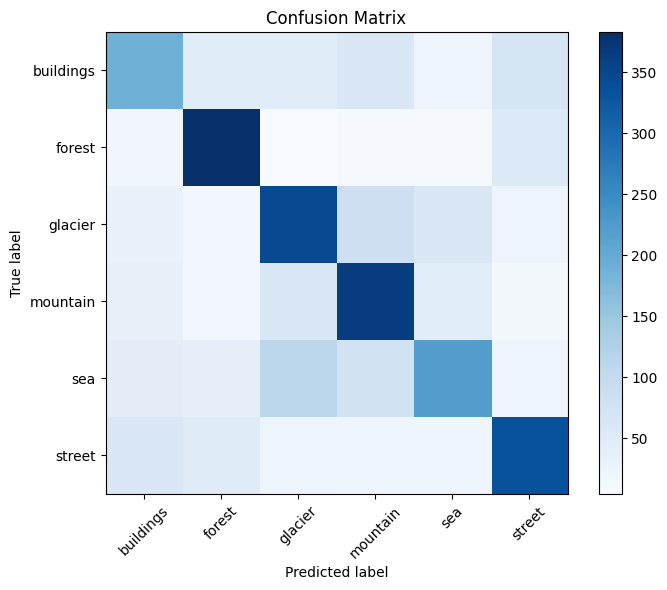

In [5]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred, target_names=categories))

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, categories, rotation=45)
    plt.yticks(tick_marks, categories)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

x_train_svc = []

x_test_svc = []

for img in x_train:

    x_train_svc.append(img.flatten())

for img in x_test:

    x_test_svc.append(img.flatten())


scaler = StandardScaler()
x_train_svc = scaler.fit_transform(np.asarray(x_train_svc))
y_train_svc = np.asarray(y_train)
x_test_svc = scaler.fit_transform(np.asarray(x_test_svc))
y_test_svc = np.asarray(y_test)


classifiers = [

    SVC(gamma=0.001),

    #DecisionTreeClassifier(max_depth=12),

    RandomForestClassifier(),

    ]


for classifier in classifiers:
    classifier.fit(x_train_svc, y_train_svc)
    y_pred_svc = classifier.predict(x_test_svc)

    plot_confusion_matrix(y_test_svc, y_pred_svc)

Epoch 1/30


c:\Users\radek\Desktop\USU\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3811 - loss: 1.8250 - val_accuracy: 0.5160 - val_loss: 1.2940
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5215 - loss: 1.2305 - val_accuracy: 0.5347 - val_loss: 1.2145
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5565 - loss: 1.1507 - val_accuracy: 0.5627 - val_loss: 1.1389
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5747 - loss: 1.1083 - val_accuracy: 0.5440 - val_loss: 1.1802
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5921 - loss: 1.0624 - val_accuracy: 0.5580 - val_loss: 1.1234
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6060 - loss: 1.0255 - val_accuracy: 0.5797 - val_loss: 1.0971
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6131 - loss: 1.0056 - val_accuracy: 0.5947 - val_loss: 1.0629
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6323 - loss: 0.9824 - val_accurac

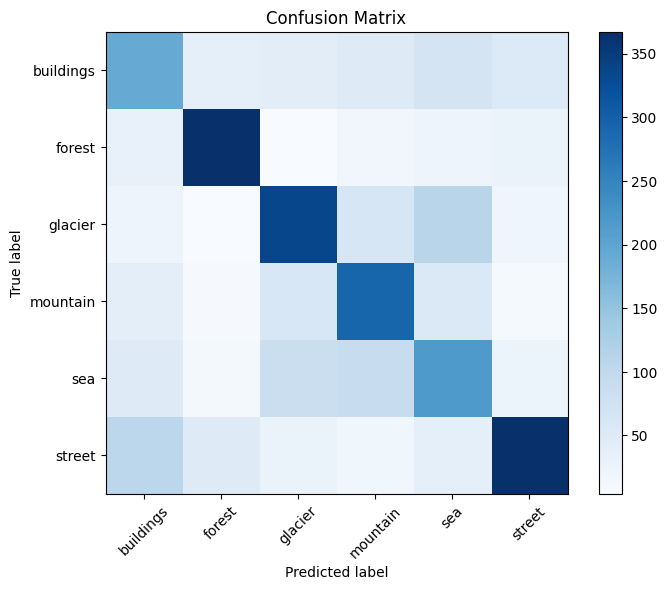

In [35]:

x_train_nn = np.asarray(x_train)
x_test_nn = np.asarray(x_test)
y_train_nn = tf.keras.utils.to_categorical(y_train, len(categories))
y_test_nn = tf.keras.utils.to_categorical(y_test, len(categories))

model = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(units = 1024, activation="relu"),
    layers.Dense(units = 512, activation="relu"),
    layers.Dense(len(categories), activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train_nn, y_train_nn, epochs=30, validation_data=(x_test_nn, y_test_nn)
)
y_pred_nn = model.predict(x_test_nn)


y_pred_nn = np.argmax(y_pred_nn, axis=1)
y_test_nn = np.argmax(y_test_nn, axis=1)
plot_confusion_matrix(y_pred_nn, y_test_nn)

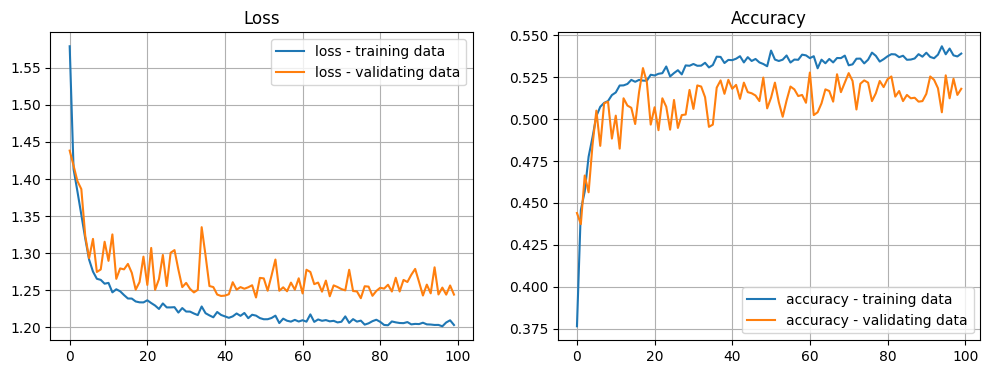

In [34]:

plt.rcParams["figure.figsize"] = [12, 4]
figure, axis = plt.subplots(1, 2)
axis[0].plot(history.history["loss"], label="loss - training data")
axis[0].plot(history.history["val_loss"], label="loss - validating data")
axis[0].grid()
axis[0].set_title("Loss")
axis[0].legend()


axis[1].plot(history.history["accuracy"], label="accuracy - training data")
axis[1].plot(history.history["val_accuracy"], label="accuracy - validating data")
axis[1].grid()
axis[1].set_title("Accuracy")
axis[1].legend()